In [80]:
import pandas as pd

# Charger les données
df = pd.read_csv("data/Quality of Service 5G.csv")

# Aperçu rapide
print("Dimensions :", df.shape)
df.head()


Dimensions : (400, 8)


,Timestamp,User_ID,Application_Type,Signal_Strength,Latency,Required_Bandwidth,Allocated_Bandwidth,Resource_Allocation
0,9/3/2023 10:00,User_1,Video_Call,-75 dBm,30 ms,10 Mbps,15 Mbps,70%
1,9/3/2023 10:00,User_2,Voice_Call,-80 dBm,20 ms,100 Kbps,120 Kbps,80%
2,9/3/2023 10:00,User_3,Streaming,-85 dBm,40 ms,5 Mbps,6 Mbps,75%
3,9/3/2023 10:00,User_4,Emergency_Service,-70 dBm,10 ms,1 Mbps,1.5 Mbps,90%
4,9/3/2023 10:00,User_5,Online_Gaming,-78 dBm,25 ms,2 Mbps,3 Mbps,85%


In [81]:
# Conversion de la latence et signal
df["Latency_ms"] = df["Latency"].str.replace(" ms", "").astype(float)
df["Signal_dBm"] = df["Signal_Strength"].str.replace(" dBm", "").astype(float)

# Conversion bande passante en Mbps
def convert_bw(x):
    if "Kbps" in x:
        return float(x.replace(" Kbps", "")) / 1000
    if "Mbps" in x:
        return float(x.replace(" Mbps", ""))
    return 0.0

df["Required_BW_Mbps"] = df["Required_Bandwidth"].apply(convert_bw)
df["Allocated_BW_Mbps"] = df["Allocated_Bandwidth"].apply(convert_bw)


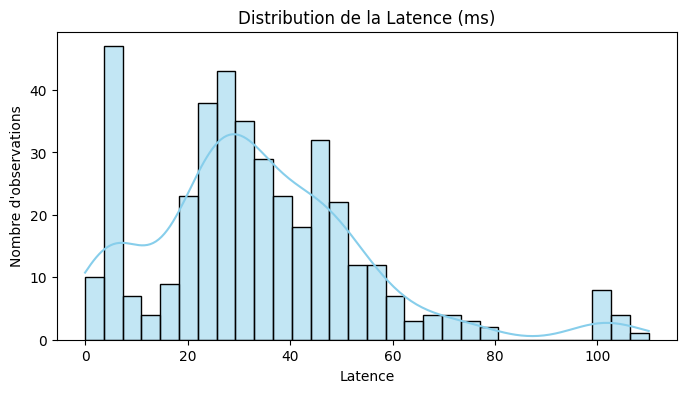

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["Latency_ms"], bins=30, kde=True, color="skyblue")
plt.title("Distribution de la Latence (ms)")
plt.xlabel("Latence")
plt.ylabel("Nombre d'observations")
plt.show()


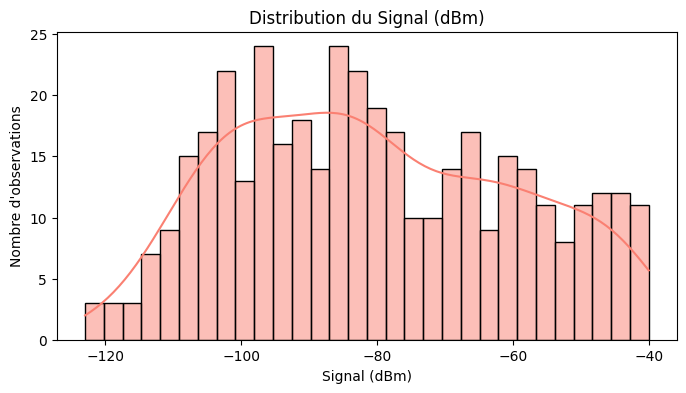

In [83]:
plt.figure(figsize=(8, 4))
sns.histplot(df["Signal_dBm"], bins=30, kde=True, color="salmon")
plt.title("Distribution du Signal (dBm)")
plt.xlabel("Signal (dBm)")
plt.ylabel("Nombre d'observations")
plt.show()


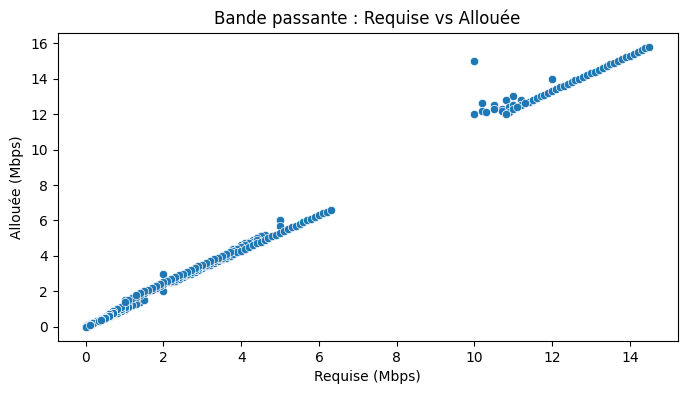

In [84]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Required_BW_Mbps", y="Allocated_BW_Mbps", data=df)
plt.title("Bande passante : Requise vs Allouée")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.show()


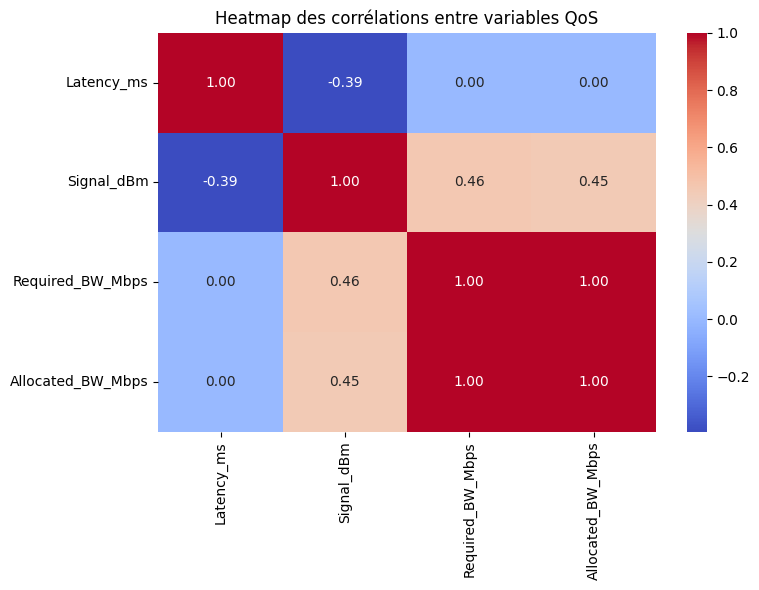

In [85]:
# Sélection des variables numériques à corréler
cols_qos = ["Latency_ms", "Signal_dBm", "Required_BW_Mbps", "Allocated_BW_Mbps"]
correlation_matrix = df[cols_qos].corr()

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap des corrélations entre variables QoS")
plt.tight_layout()
plt.savefig("graphs/correlation_heatmap.png")
plt.show()


In [86]:
# Seuils simples d'anomalies
seuil_latence = 100         # > 100 ms = trop lent
seuil_signal = -90          # < -90 dBm = très mauvais signal
df["Anomalie_Latence"] = df["Latency_ms"] > seuil_latence
df["Anomalie_Signal"] = df["Signal_dBm"] < seuil_signal
df["Anomalie_BW"] = df["Allocated_BW_Mbps"] < df["Required_BW_Mbps"]

# Création d'une colonne générale : est-ce qu'au moins UNE anomalie ?
df["Anomalie_Global"] = df[["Anomalie_Latence", "Anomalie_Signal", "Anomalie_BW"]].any(axis=1)

# Résumé
print("Anomalies détectées :")
print(df[["Anomalie_Latence", "Anomalie_Signal", "Anomalie_BW", "Anomalie_Global"]].sum())


Anomalies détectées :
Anomalie_Latence      7
Anomalie_Signal     143
Anomalie_BW           0
Anomalie_Global     143
dtype: int64


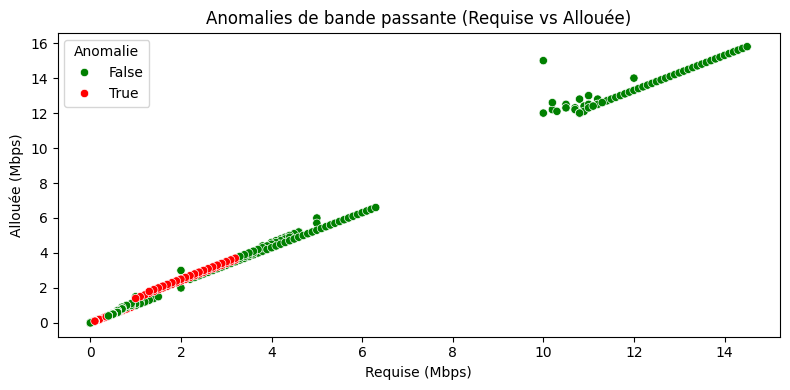

In [87]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x="Required_BW_Mbps", y="Allocated_BW_Mbps", hue="Anomalie_Global", data=df, palette=["green", "red"])
plt.title("Anomalies de bande passante (Requise vs Allouée)")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.legend(title="Anomalie")
plt.tight_layout()
plt.savefig("graphs/anomalie_bw.png")
plt.show()


C:\Users\ndeye\AppData\Local\Temp\ipykernel_21232\2256930418.py:3: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.scatterplot(


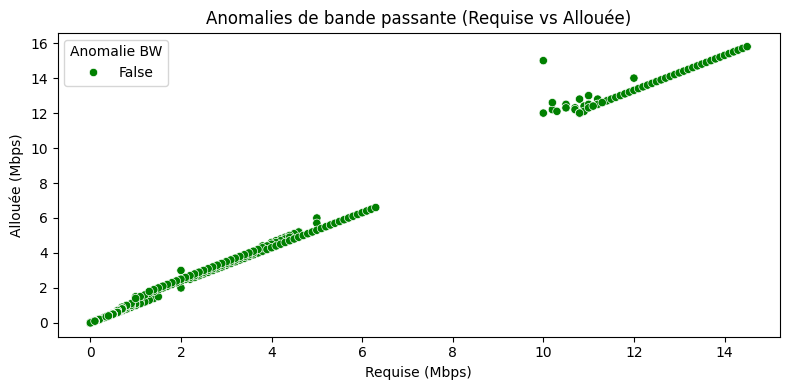

In [88]:
#Anomalie de bande passante
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x="Required_BW_Mbps", 
    y="Allocated_BW_Mbps", 
    hue="Anomalie_BW", 
    data=df, 
    palette=["green", "red"]
)
plt.title("Anomalies de bande passante (Requise vs Allouée)")
plt.xlabel("Requise (Mbps)")
plt.ylabel("Allouée (Mbps)")
plt.legend(title="Anomalie BW")
plt.tight_layout()
plt.savefig("graphs/anomalie_bw_seule.png")
plt.show()


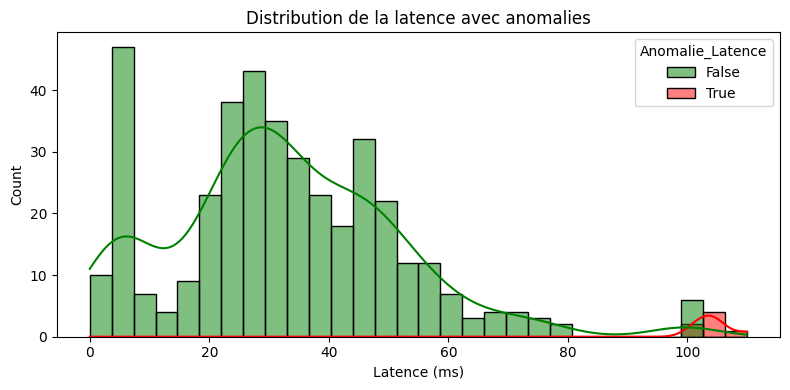

In [89]:
#Anomalie de latence
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="Latency_ms", hue="Anomalie_Latence", bins=30, kde=True, palette=["green", "red"])
plt.title("Distribution de la latence avec anomalies")
plt.xlabel("Latence (ms)")
plt.tight_layout()
plt.savefig("graphs/anomalie_latence.png")
plt.show()


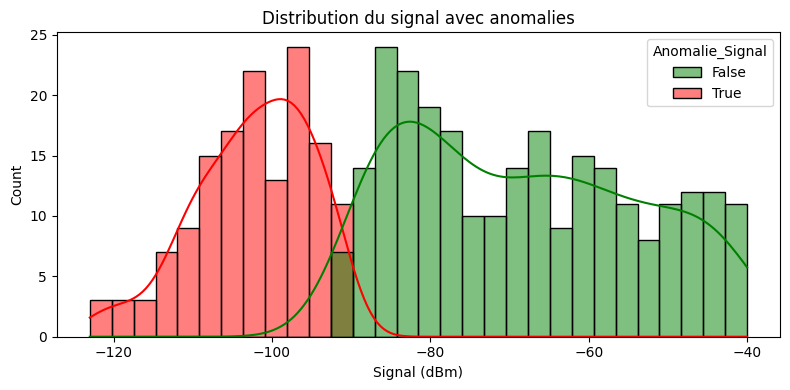

In [90]:
#Anomalie de signal
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="Signal_dBm", hue="Anomalie_Signal", bins=30, kde=True, palette=["green", "red"])
plt.title("Distribution du signal avec anomalies")
plt.xlabel("Signal (dBm)")
plt.tight_layout()
plt.savefig("graphs/anomalie_signal.png")
plt.show()


In [91]:
df_anomalies = df[df["Anomalie_Global"] == True]
df_anomalies.to_csv("reports/anomalies_detectees.csv", index=False)
print("📁 Anomalies enregistrées dans 'reports/anomalies_detectees.csv'")


📁 Anomalies enregistrées dans 'reports/anomalies_detectees.csv'


Époque 50/1000, Perte = 325.3675
Époque 100/1000, Perte = 70.4151
Époque 150/1000, Perte = 42.8046
Époque 200/1000, Perte = 30.1001
Époque 250/1000, Perte = 20.0674
Époque 300/1000, Perte = 12.8440
Époque 350/1000, Perte = 7.7265
Époque 400/1000, Perte = 5.0669
Époque 450/1000, Perte = 3.3803
Époque 500/1000, Perte = 2.4589
Époque 550/1000, Perte = 2.1032
Époque 600/1000, Perte = 1.9890
Époque 650/1000, Perte = 1.9249
Époque 700/1000, Perte = 1.8885
Époque 750/1000, Perte = 1.8561
Époque 800/1000, Perte = 1.8261
Époque 850/1000, Perte = 1.7963
Époque 900/1000, Perte = 1.7942
Époque 950/1000, Perte = 1.7377
Époque 1000/1000, Perte = 1.7098


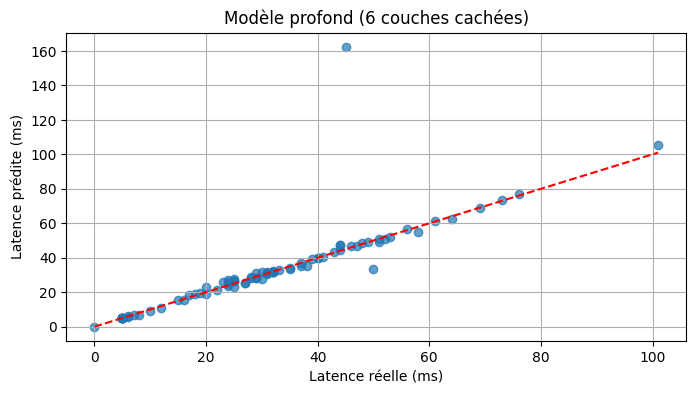

In [92]:
# === Phase 2 : Modèle de Prédiction avec PyTorch ===

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
# Encodage simple : One-hot de Application_Type
df_encoded = pd.get_dummies(df, columns=["Application_Type"], drop_first=True)
# Étape 1 : Sélection des features et de la target
features = df_encoded.drop(columns=["Timestamp", "User_ID", "Latency", "Signal_Strength", "Required_Bandwidth", "Allocated_Bandwidth", "Resource_Allocation", "Latency_ms"])  
features["Signal_dBm"] = df["Signal_dBm"]
features["Required_BW_Mbps"] = df["Required_BW_Mbps"]
features["Allocated_BW_Mbps"] = df["Allocated_BW_Mbps"]
target = df["Latency_ms"]

# Normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(features)
y = target.values

# Conversion en tenseurs PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Séparation train / test
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# === Modèle profond avec 6 couches cachées ===

class DeepLatencyModel6Layers(nn.Module):
    def __init__(self):
        super(DeepLatencyModel6Layers, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        return self.output(x)

# Instanciation du modèle, fonction de perte et optimiseur
model = DeepLatencyModel6Layers()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entraînement
epochs = 1000
for epoch in range(epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Époque {epoch+1}/{epochs}, Perte = {loss.item():.4f}")

# Évaluation
model.eval()
with torch.no_grad():
    predictions = model(X_test).numpy()
    true = y_test.numpy()

# Graphe
plt.figure(figsize=(8, 4))
plt.scatter(true, predictions, alpha=0.7)
plt.xlabel("Latence réelle (ms)")
plt.ylabel("Latence prédite (ms)")
plt.title("Modèle profond (6 couches cachées)")
plt.grid(True)
plt.plot([min(true), max(true)], [min(true), max(true)], "r--")
plt.show()

Epoch 0, Latency Loss: 1636.5950, Adversarial: 2.3771
Epoch 50, Latency Loss: 798.7629, Adversarial: 10.8492
Epoch 100, Latency Loss: 90.5154, Adversarial: 113.8622
Epoch 150, Latency Loss: 53.8788, Adversarial: 280.1204
Epoch 200, Latency Loss: 40.6525, Adversarial: 477.2626
Epoch 250, Latency Loss: 32.3682, Adversarial: 673.7059
Epoch 300, Latency Loss: 26.3335, Adversarial: 824.7874
Epoch 350, Latency Loss: 20.4418, Adversarial: 904.5353
Epoch 400, Latency Loss: 13.6671, Adversarial: 883.3420
Epoch 450, Latency Loss: 7.9839, Adversarial: 759.0195
Epoch 500, Latency Loss: 4.9138, Adversarial: 633.2424
Epoch 550, Latency Loss: 3.6656, Adversarial: 530.3615


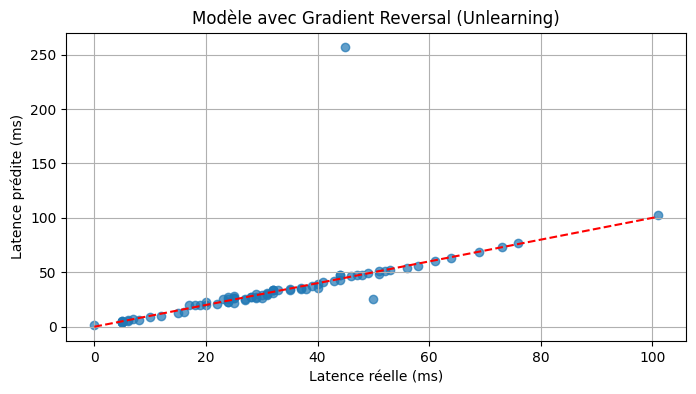

In [93]:
from sklearn.preprocessing import LabelEncoder
from torch.autograd import Function
import torch.nn as nn
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Encodage Application_Type pour la tâche adversaire
label_encoder = LabelEncoder()
y_adv = label_encoder.fit_transform(df["Application_Type"])
y_adv_tensor = torch.tensor(y_adv, dtype=torch.long)

# Encodage des features
df_encoded = pd.get_dummies(df, columns=["Application_Type"], drop_first=True)

features = df_encoded.drop(columns=["Timestamp", "User_ID", "Latency", "Signal_Strength", "Required_Bandwidth", "Allocated_Bandwidth", "Resource_Allocation", "Latency_ms"])
features["Signal_dBm"] = df["Signal_dBm"]
features["Required_BW_Mbps"] = df["Required_BW_Mbps"]
features["Allocated_BW_Mbps"] = df["Allocated_BW_Mbps"]
target = df["Latency_ms"]

scaler = StandardScaler()
X = scaler.fit_transform(features)
y = target.values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Split
X_train, X_test, y_train, y_test, y_train_adv, y_test_adv = train_test_split(
    X_tensor, y_tensor, y_adv_tensor, test_size=0.2, random_state=42
)

# === Gradient Reversal ===
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, input, lambda_):
        ctx.lambda_ = lambda_
        return input.view_as(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradientReversalFunction.apply(x, lambda_)

# === Modèle avec unlearning ===
class GradientUnlearningModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GradientUnlearningModel, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.regressor = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.adversary = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x, lambda_=1.0):
        shared_feat = self.shared(x)
        reverse_feat = grad_reverse(shared_feat, lambda_)
        return self.regressor(shared_feat), self.adversary(reverse_feat)

# === Entraînement ===
input_dim = X.shape[1]
num_classes = len(label_encoder.classes_)

model = GradientUnlearningModel(input_dim, num_classes)
criterion_reg = nn.MSELoss()
criterion_adv = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 600
for epoch in range(epochs):
    model.train()
    pred_latency, pred_app_type = model(X_train, lambda_=1.0)

    loss_latency = criterion_reg(pred_latency, y_train)
    loss_adversarial = criterion_adv(pred_app_type, y_train_adv)

    total_loss = loss_latency - 0.1 * loss_adversarial

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Latency Loss: {loss_latency.item():.4f}, Adversarial: {loss_adversarial.item():.4f}")

# === Évaluation ===
model.eval()
with torch.no_grad():
    pred_latency, _ = model(X_test)
    predictions = pred_latency.numpy()
    true = y_test.numpy()

plt.figure(figsize=(8, 4))
plt.scatter(true, predictions, alpha=0.7)
plt.xlabel("Latence réelle (ms)")
plt.ylabel("Latence prédite (ms)")
plt.title("Modèle avec Gradient Reversal (Unlearning)")
plt.grid(True)
plt.plot([min(true), max(true)], [min(true), max(true)], "r--")
plt.show()

Avant unlearning : 3.50238
Après unlearning : 3.61985788113695


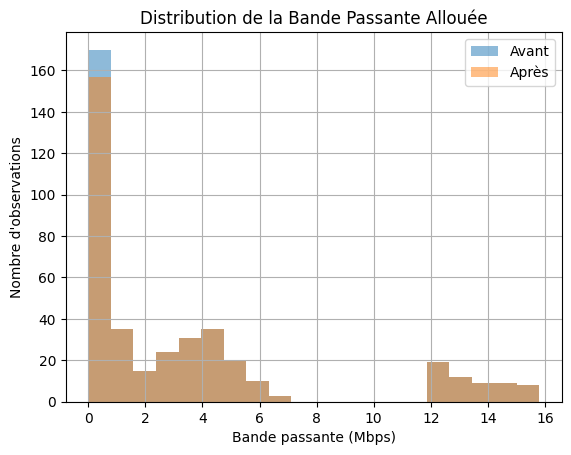

In [94]:
print("Avant unlearning :", df["Allocated_BW_Mbps"].mean())
print("Après unlearning :", df_unlearned["Allocated_BW_Mbps"].mean())

plt.hist(df["Allocated_BW_Mbps"], bins=20, alpha=0.5, label="Avant")
plt.hist(df_unlearned["Allocated_BW_Mbps"], bins=20, alpha=0.5, label="Après")
plt.title("Distribution de la Bande Passante Allouée")
plt.xlabel("Bande passante (Mbps)")
plt.ylabel("Nombre d'observations")
plt.legend()
plt.grid(True)
plt.show()

Avant unlearning : 74.7125
Après unlearning : 74.85788113695091


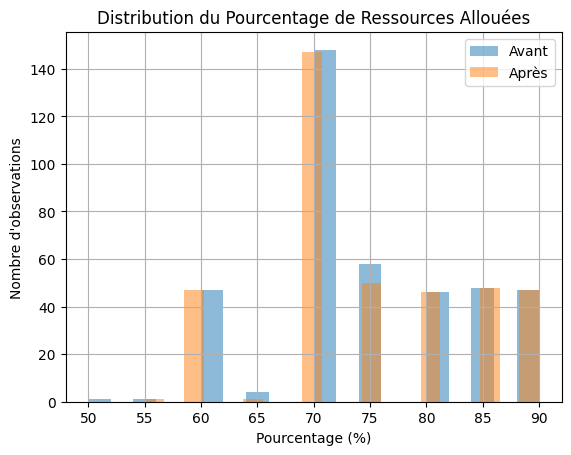

In [95]:
# Conversion texte → float si ce n'est pas déjà fait
df["Resource_Allocation"] = df["Resource_Allocation"].str.replace('%', '').astype(float)
df_unlearned["Resource_Allocation"] = df_unlearned["Resource_Allocation"].str.replace('%', '').astype(float)

# Moyenne
print("Avant unlearning :", df["Resource_Allocation"].mean())
print("Après unlearning :", df_unlearned["Resource_Allocation"].mean())

# Histogramme
plt.hist(df["Resource_Allocation"], bins=20, alpha=0.5, label="Avant")
plt.hist(df_unlearned["Resource_Allocation"], bins=20, alpha=0.5, label="Après")
plt.title("Distribution du Pourcentage de Ressources Allouées")
plt.xlabel("Pourcentage (%)")
plt.ylabel("Nombre d'observations")
plt.legend()
plt.grid(True)
plt.show()

Avant unlearning : -80.495
Après unlearning : -79.83204134366925


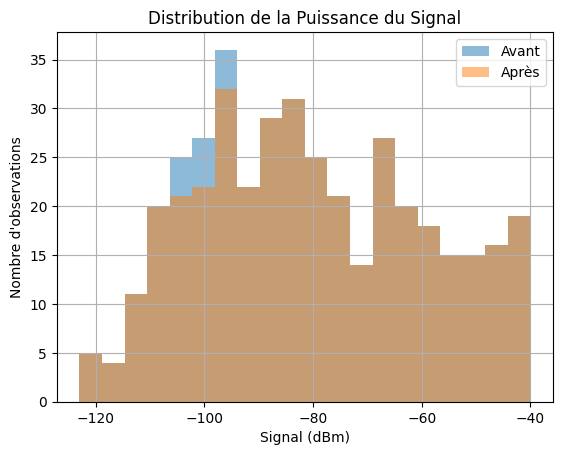

In [96]:
# Moyenne
print("Avant unlearning :", df["Signal_dBm"].mean())
print("Après unlearning :", df_unlearned["Signal_dBm"].mean())

# Histogramme
plt.hist(df["Signal_dBm"], bins=20, alpha=0.5, label="Avant")
plt.hist(df_unlearned["Signal_dBm"], bins=20, alpha=0.5, label="Après")
plt.title("Distribution de la Puissance du Signal")
plt.xlabel("Signal (dBm)")
plt.ylabel("Nombre d'observations")
plt.legend()
plt.grid(True)
plt.show()